In [ ]:
# =========================
# LGBM
# =========================

import pandas as pd
import numpy as np
import random
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb

# =========================
# 0. 전역 시드 고정 (재현성 확보)
# =========================
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

FEATURE_PATH = "/content/drive/MyDrive/기계학습/팀플/Data/학사일정_정리(2325).csv"
TRAIN_PATH   = "/content/drive/MyDrive/기계학습/팀플/Data/ENG_POS_train_val.csv"
TEST_PATH = "/content/drive/MyDrive/기계학습/팀플/Data/ENG_POS_test.csv"


# =========================
# 1. 유틸 함수들
# =========================
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    return np.mean(
        2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    ) * 100


def calculate_operating_hours(row):
    weekday = row["weekday"]
    semester = row["semester"]
    holiday = row["holiday"]

    # 일요일 미운영
    if weekday == "sun":
        return 0

    # 학기 중
    if semester == 1:
        if holiday == 1:
            return 7
        if weekday in ["mon", "tue", "wed", "thu", "fri"]:
            return 12
        if weekday == "sat":
            return 7
        return 0

    # 방학 중
    else:
        if holiday == 1:
            return 0
        if weekday in ["mon", "tue", "wed", "thu", "fri", "sat"]:
            return 7
        return 0


# =========================
# 2. 메인 파이프라인
# =========================
def run_lgbm(feature_path=FEATURE_PATH, train_path=TRAIN_PATH, test_path=TEST_PATH):

    # ---------- (1) 데이터 로드 ----------
    feat = pd.read_csv(feature_path)
    pos_train = pd.read_csv(train_path)
    pos_test = pd.read_csv(test_path)

    # 숫자 전처리
    for df in [pos_train, pos_test]:
        for col in ["daily", "AOV"]:
            df[col] = (
                df[col].astype(str).str.replace(",", "", regex=False).astype(float)
            )
        df["date"] = pd.to_datetime(df["date"])

    feat["date"] = pd.to_datetime(feat["date"])

    # train/test 결합
    pos_train["set"] = "train"
    pos_test["set"] = "test"

    # 전체 병합 (Static Feature 계산용)
    pos_all = pd.concat([pos_train, pos_test], ignore_index=True)
    df_all = pd.merge(pos_all, feat, on="date", how="left")
    df_all = df_all.sort_values("date").reset_index(drop=True)

    print("All merged shape:", df_all.shape)

    # ---------- (2) Static Feature Engineering ----------
    df_all["operating_hours"] = df_all.apply(calculate_operating_hours, axis=1)

    # [New Feature] Month (계절성 반영)
    df_all["month"] = df_all["date"].dt.month

    df_all["exam_before3"] = df_all["exam"].shift(1).rolling(3, min_periods=1).sum().fillna(0)
    df_all["exam_after3"] = df_all["exam"].shift(-1).rolling(3, min_periods=1).sum().fillna(0)

    df_all["semester_weekend"] = df_all["semester"] * df_all["weekend"]

    df_all = pd.get_dummies(df_all, columns=["weekday"], drop_first=True)

    # ---------- (3) Train/Test 분리 ----------
    df_train_val = df_all[df_all["set"] == "train"].copy()
    df_test_static = df_all[df_all["set"] == "test"].copy()

    print("\nGenerating features for Training set...")
    lag_list = [1, 2, 3, 7, 14, 28]
    win_list = [7, 14, 28]

    for lag in lag_list:
        df_train_val[f"Lag{lag}"] = df_train_val["daily"].shift(lag)

    for win in win_list:
        roll = df_train_val["daily"].rolling(window=win, min_periods=1)
        df_train_val[f"RollingMean{win}"] = roll.mean().shift(1)
        df_train_val[f"RollingStd{win}"] = roll.std(ddof=0).shift(1)

    feature_na_cols = [f"Lag{l}" for l in lag_list] + \
                      [f"RollingMean{w}" for w in win_list] + \
                      [f"RollingStd{w}" for w in win_list]

    df_train_val_clean = df_train_val.dropna(subset=feature_na_cols).reset_index(drop=True)
    df_train_val_clean = df_train_val_clean[df_train_val_clean["daily"] > 0].copy()

    print("Train_val prepared:", df_train_val_clean.shape)

    # ---------- (4) Train/Val Split & Model Training (Log Transform) ----------
    df_sorted = df_train_val_clean.sort_values("date").reset_index(drop=True)
    split_idx = int(len(df_sorted) * 0.8)

    train = df_sorted.iloc[:split_idx]
    val = df_sorted.iloc[split_idx:]

    drop_cols = ["date", "daily", "num", "AOV", "set"]
    feature_cols = [c for c in df_sorted.columns if c not in drop_cols]

    X_train = train[feature_cols]
    y_train = np.log1p(train["daily"]) # Log Transform
    X_val = val[feature_cols]
    y_val = np.log1p(val["daily"])     # Log Transform

    print(f"Training with {len(feature_cols)} features (Target Log-Transformed)...")

    from itertools import product
    param_grid = {
        "num_leaves":       [15, 31],
        "learning_rate":    [0.03, 0.05],
        "n_estimators":     [400, 800],
        "min_child_samples":[20],
        "subsample":        [0.8],
        "colsample_bytree": [0.8],
    }

    best_rmse = np.inf
    best_params = None

    for num_leaves, lr, n_estimators, min_child, subsample, colsample in product(
        param_grid["num_leaves"], param_grid["learning_rate"], param_grid["n_estimators"],
        param_grid["min_child_samples"], param_grid["subsample"], param_grid["colsample_bytree"],
    ):
        params = {
            "num_leaves": num_leaves, "learning_rate": lr, "n_estimators": n_estimators,
            "min_child_samples": min_child, "subsample": subsample, "colsample_bytree": colsample,
        }
        reg_tmp = lgb.LGBMRegressor(
            objective="regression", random_state=SEED, verbosity=-1, **params
        )
        reg_tmp.fit(X_train, y_train)
        val_pred_tmp = reg_tmp.predict(X_val)
        rmse_tmp = np.sqrt(mean_squared_error(y_val, val_pred_tmp))

        if rmse_tmp < best_rmse:
            best_rmse = rmse_tmp
            best_params = params

    print(f"Best Params: {best_params}")

    # Final Fit
    reg = lgb.LGBMRegressor(objective="regression", random_state=SEED, verbosity=-1, **best_params)
    reg.fit(df_sorted[feature_cols], np.log1p(df_sorted["daily"])) # Final Fit with Log

    # ---------- (5) Recursive Forecasting for Test (Black Box Simulation) ----------
    print("\nStarting Recursive Forecasting for Test Set...")

    history_df = df_train_val.iloc[-60:].copy()
    test_preds = []

    for idx, row in df_test_static.iterrows():
        current_row = row.to_frame().T
        current_row["daily"] = np.nan

        temp_history = pd.concat([history_df, current_row], ignore_index=True)

        for lag in lag_list:
            temp_history[f"Lag{lag}"] = temp_history["daily"].shift(lag)

        for win in win_list:
            roll = temp_history["daily"].rolling(window=win, min_periods=1)
            temp_history[f"RollingMean{win}"] = roll.mean().shift(1)
            temp_history[f"RollingStd{win}"] = roll.std(ddof=0).shift(1)

        X_test_single = temp_history.iloc[[-1]][feature_cols]
        X_test_single = X_test_single.astype(float)

        # Predict Log Value
        pred_log = reg.predict(X_test_single)[0]

        # Inverse Transform (Exp)
        pred = np.expm1(pred_log)

        test_preds.append(pred)

        current_row["daily"] = pred
        history_df = pd.concat([history_df, current_row], ignore_index=True).iloc[-60:]

    # ---------- (6) 성능 평가 ----------
    # 실제값 가져오기 (평가용으로만 사용)
    y_test_actual = df_test_static["daily"].values

    # 0인 날짜 제외하고 평가 (기존 로직 따름)
    # 단, 예측은 모든 날짜에 대해 수행했으므로 인덱싱으로 필터링
    mask = y_test_actual > 0

    final_actual = y_test_actual[mask]
    final_pred = np.array(test_preds)[mask]

    mae_test = mean_absolute_error(final_actual, final_pred)
    rmse_test = np.sqrt(mean_squared_error(final_actual, final_pred))
    smape_test = smape(final_actual, final_pred)

    print("\n===== Test Performance (Recursive / Black-box) =====")
    print(f"MAE   : {mae_test:,.2f}")
    print(f"RMSE  : {rmse_test:,.2f}")
    print(f"SMAPE : {smape_test:.2f}%")

    # 결과 저장
    result_df = df_test_static.copy()
    result_df["pred_daily"] = test_preds
    result_df = result_df[result_df["daily"] > 0] # 평가 기준 동일하게 저장

    result_df = result_df[["date", "daily", "pred_daily"]].rename(columns={"daily": "actual_daily"})
    result_df.to_csv("lgbm_prediction_recursive.csv", index=False, encoding="utf-8-sig")

    metrics = {
        "model": "LGBM_Recursive",
        "test_MAE": mae_test,
        "test_RMSE": rmse_test,
        "test_SMAPE": smape_test,
    }

    return metrics, result_df

if __name__ == "__main__":
    metrics, df_pred = run_lgbm()
    print("\n[DEBUG] Metrics:", metrics)
    print(df_pred.head())


All merged shape: (875, 13)

Generating features for Training set...
Train_val prepared: (534, 35)
Training with 30 features (Target Log-Transformed)...
Best Params: {'num_leaves': 15, 'learning_rate': 0.03, 'n_estimators': 400, 'min_child_samples': 20, 'subsample': 0.8, 'colsample_bytree': 0.8}

Starting Recursive Forecasting for Test Set...

===== Test Performance (Recursive / Black-box) =====
MAE   : 87,775.69
RMSE  : 105,128.29
SMAPE : 32.44%

[DEBUG] Metrics: {'model': 'LGBM_Recursive', 'test_MAE': 87775.69056120144, 'test_RMSE': np.float64(105128.29402745338), 'test_SMAPE': np.float64(32.43940291462401)}
          date  actual_daily     pred_daily
742 2025-08-12       81300.0  183791.575690
743 2025-08-13      114900.0  162190.024162
755 2025-08-25       88200.0  121501.203628
756 2025-08-26       91600.0  131100.345311
757 2025-08-27      117700.0  152465.450320


In [ ]:
# =========================
# XGBoost
# =========================

import pandas as pd
import numpy as np
import random
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

# =========================
# ⭐ 전역 시드 고정 (재현성 보장)
# =========================
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

FEATURE_PATH = "/content/drive/MyDrive/기계학습/팀플/Data/학사일정_정리(2325).csv"
TRAIN_PATH   = "/content/drive/MyDrive/기계학습/팀플/Data/ENG_POS_train_val.csv"
TEST_PATH = "/content/drive/MyDrive/기계학습/팀플/Data/ENG_POS_test.csv"

# =========================
# 1. 유틸 함수들
# =========================
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    return np.mean(
        2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    ) * 100


def calculate_operating_hours(row):
    weekday = row["weekday"]
    semester = row["semester"]
    holiday = row["holiday"]

    if weekday == "sun":
        return 0

    if semester == 1:
        if holiday == 1:
            return 7
        if weekday in ["mon", "tue", "wed", "thu", "fri"]:
            return 12
        if weekday == "sat":
            return 7
        return 0

    else:
        if holiday == 1:
            return 0
        if weekday in ["mon", "tue", "wed", "thu", "fri", "sat"]:
            return 7
        return 0


# =========================
# 2. 메인 파이프라인
# =========================
def run_xgb(feature_path=FEATURE_PATH, train_path=TRAIN_PATH, test_path=TEST_PATH):

    # ---------- (1) 데이터 로드 ----------
    feat = pd.read_csv(feature_path)
    pos_train = pd.read_csv(train_path)
    pos_test = pd.read_csv(test_path)

    for df in [pos_train, pos_test]:
        for col in ["daily", "AOV"]:
            df[col] = (
                df[col].astype(str).str.replace(",", "", regex=False).astype(float)
            )
        df["date"] = pd.to_datetime(df["date"])

    feat["date"] = pd.to_datetime(feat["date"])

    pos_train["set"] = "train"
    pos_test["set"] = "test"

    # 전체 병합 (Static Feature 계산용)
    pos_all = pd.concat([pos_train, pos_test], ignore_index=True)
    df_all = pd.merge(pos_all, feat, on="date", how="left")
    df_all = df_all.sort_values("date").reset_index(drop=True)

    print("All merged shape:", df_all.shape)

    # ---------- (2) Static Feature Engineering ----------
    df_all["operating_hours"] = df_all.apply(calculate_operating_hours, axis=1)

    # [New Feature] Month (계절성 반영)
    df_all["month"] = df_all["date"].dt.month

    df_all["exam_before3"] = df_all["exam"].shift(1).rolling(3, min_periods=1).sum().fillna(0)
    df_all["exam_after3"] = df_all["exam"].shift(-1).rolling(3, min_periods=1).sum().fillna(0)

    df_all["semester_weekend"] = df_all["semester"] * df_all["weekend"]

    df_all = pd.get_dummies(df_all, columns=["weekday"], drop_first=True)

    # ---------- (3) Train/Test 분리 ----------
    df_train_val = df_all[df_all["set"] == "train"].copy()
    df_test_static = df_all[df_all["set"] == "test"].copy() # daily 값은 평가용으로만 씀

    # [Train Phase] 학습 데이터에는 실제 daily 값을 이용하여 Lag 생성
    print("\nGenerating features for Training set...")
    lag_list = [1, 2, 3, 7, 14, 28]
    win_list = [7, 14, 28]

    for lag in lag_list:
        df_train_val[f"Lag{lag}"] = df_train_val["daily"].shift(lag)

    for win in win_list:
        roll = df_train_val["daily"].rolling(window=win, min_periods=1)
        df_train_val[f"RollingMean{win}"] = roll.mean().shift(1)
        df_train_val[f"RollingStd{win}"] = roll.std(ddof=0).shift(1)

    # NaN 제거
    feature_na_cols = [f"Lag{l}" for l in lag_list] + \
                      [f"RollingMean{w}" for w in win_list] + \
                      [f"RollingStd{w}" for w in win_list]

    df_train_val_clean = df_train_val.dropna(subset=feature_na_cols).reset_index(drop=True)
    df_train_val_clean = df_train_val_clean[df_train_val_clean["daily"] > 0].copy()

    print("Train_val prepared:", df_train_val_clean.shape)

    # ---------- (4) Train/Val Split & Model Training (Log Transform) ----------
    df_sorted = df_train_val_clean.sort_values("date").reset_index(drop=True)
    split_idx = int(len(df_sorted) * 0.8)

    train = df_sorted.iloc[:split_idx]
    val = df_sorted.iloc[split_idx:]

    drop_cols = ["date", "daily", "num", "AOV", "set"]
    feature_cols = [c for c in df_sorted.columns if c not in drop_cols]

    X_train = train[feature_cols]
    y_train = np.log1p(train["daily"]) # Log Transform
    X_val = val[feature_cols]
    y_val = np.log1p(val["daily"])     # Log Transform

    print(f"Training with {len(feature_cols)} features (Target Log-Transformed)...")

    from itertools import product

    param_grid = {
        "max_depth":        [4, 5, 6],
        "learning_rate":    [0.03, 0.05],
        "n_estimators":     [400, 800],
        "min_child_weight": [2, 4],
        "subsample":        [0.7, 0.9],
        "colsample_bytree": [0.7, 0.9],
    }

    best_rmse = np.inf
    best_params = None

    print("\n===== Hyperparameter Search (based on Val RMSE, XGBoost) =====")

    for max_depth, lr, n_estimators, min_child_weight, subsample, colsample in product(
        param_grid["max_depth"],
        param_grid["learning_rate"],
        param_grid["n_estimators"],
        param_grid["min_child_weight"],
        param_grid["subsample"],
        param_grid["colsample_bytree"],
    ):
        params = {
            "objective": "reg:squarederror",
            "max_depth": max_depth,
            "learning_rate": lr,
            "n_estimators": n_estimators,
            "min_child_weight": min_child_weight,
            "subsample": subsample,
            "colsample_bytree": colsample,
            "random_state": SEED,
            "n_jobs": -1,
            "tree_method": "hist",
            "sampling_method": "uniform",
            "enable_categorical": False,
        }

        reg_tmp = xgb.XGBRegressor(**params)

        reg_tmp.fit(X_train, y_train)
        val_pred_tmp = reg_tmp.predict(X_val)
        rmse_tmp = np.sqrt(mean_squared_error(y_val, val_pred_tmp))

        if rmse_tmp < best_rmse:
            best_rmse = rmse_tmp
            best_params = params

    print("\n>>> Best Params (by Val RMSE):")
    print(best_params)
    print(f">>> Best Val RMSE: {best_rmse:,.4f}")

    # Final Fit
    reg = xgb.XGBRegressor(**best_params)
    reg.fit(df_sorted[feature_cols], np.log1p(df_sorted["daily"]))

    # ---------- (5) Recursive Forecasting for Test (Black Box Simulation) ----------
    print("\nStarting Recursive Forecasting for Test Set...")

    history_df = df_train_val.iloc[-60:].copy()
    test_preds = []

    for idx, row in df_test_static.iterrows():
        # 1. 현재 예측할 날짜의 기본 정보 가져오기
        current_row = row.to_frame().T
        current_row["daily"] = np.nan

        # 2. History에 임시 추가
        temp_history = pd.concat([history_df, current_row], ignore_index=True)

        # 3. Feature Engineering (Lag/Rolling)
        for lag in lag_list:
            temp_history[f"Lag{lag}"] = temp_history["daily"].shift(lag)

        for win in win_list:
            roll = temp_history["daily"].rolling(window=win, min_periods=1)
            temp_history[f"RollingMean{win}"] = roll.mean().shift(1)
            temp_history[f"RollingStd{win}"] = roll.std(ddof=0).shift(1)

        # 4. 예측 수행
        X_test_single = temp_history.iloc[[-1]][feature_cols]

        # [Bug Fix] Object -> Float 변환
        X_test_single = X_test_single.astype(float)

        # Predict Log Value
        pred_log = reg.predict(X_test_single)[0]

        # Inverse Transform (Exp)
        pred = np.expm1(pred_log)

        test_preds.append(pred)

        # 5. History 업데이트 (예측값을 daily로 확정)
        current_row["daily"] = pred
        history_df = pd.concat([history_df, current_row], ignore_index=True).iloc[-60:]

    # ---------- (6) 성능 평가 ----------
    y_test_actual = df_test_static["daily"].values

    mask = y_test_actual > 0
    final_actual = y_test_actual[mask]
    final_pred = np.array(test_preds)[mask]

    mae_test = mean_absolute_error(final_actual, final_pred)
    rmse_test = np.sqrt(mean_squared_error(final_actual, final_pred))
    smape_test = smape(final_actual, final_pred)

    print("\n===== Test Performance (Recursive / Black-box / XGBoost) =====")
    print(f"MAE   : {mae_test:,.2f}")
    print(f"RMSE  : {rmse_test:,.2f}")
    print(f"SMAPE : {smape_test:.2f}%")

    result_df = df_test_static.copy()
    result_df["pred_daily"] = test_preds
    result_df = result_df[result_df["daily"] > 0]

    result_df = result_df[["date", "daily", "pred_daily"]].rename(columns={"daily": "actual_daily"})
    result_df.to_csv("xgb_prediction_recursive.csv", index=False, encoding="utf-8-sig")

    metrics = {
        "model": "XGB_Recursive",
        "test_MAE": mae_test,
        "test_RMSE": rmse_test,
        "test_SMAPE": smape_test,
    }

    return metrics, result_df


if __name__ == "__main__":
    metrics, df_pred = run_xgb()
    print("\n[DEBUG] XGB metrics:", metrics)
    print(df_pred.head())


All merged shape: (875, 13)

Generating features for Training set...
Train_val prepared: (534, 35)
Training with 30 features (Target Log-Transformed)...

===== Hyperparameter Search (based on Val RMSE, XGBoost) =====

>>> Best Params (by Val RMSE):
{'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.03, 'n_estimators': 400, 'min_child_weight': 4, 'subsample': 0.9, 'colsample_bytree': 0.7, 'random_state': 42, 'n_jobs': -1, 'tree_method': 'hist', 'sampling_method': 'uniform', 'enable_categorical': False}
>>> Best Val RMSE: 0.2963

Starting Recursive Forecasting for Test Set...

===== Test Performance (Recursive / Black-box / XGBoost) =====
MAE   : 82,664.52
RMSE  : 101,496.47
SMAPE : 31.18%

[DEBUG] XGB metrics: {'model': 'XGB_Recursive', 'test_MAE': 82664.51606721699, 'test_RMSE': np.float64(101496.46833369741), 'test_SMAPE': np.float64(31.179856318643633)}
          date  actual_daily     pred_daily
742 2025-08-12       81300.0  166036.031250
743 2025-08-13      114900

In [ ]:
# =========================
# LSTM
# =========================

import os
import random
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# ============================================================
# 🔒 0. 재현성 보장 Seed 설정 (deterministic 알고리즘 강제 OFF 버전)
# ============================================================
SEED = 42

# Python RNG
random.seed(SEED)

# NumPy RNG
np.random.seed(SEED)

# PyTorch RNG
torch.manual_seed(SEED)

# GPU RNG
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

# CuDNN 결정성 모드 (LSTM 안정적 재현)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ❌ torch.use_deterministic_algorithms(True) 제거
# (CuBLAS 연산 오류 방지, 일반적 구성)

# ==================================================================
# 0. 영업 시간 계산 유틸리티 함수 (원본 그대로 유지)
# ==================================================================
def calculate_operating_hours(row):
    weekday = row["weekday"]
    if weekday == 6:
        return 0.0
    if weekday == 5:
        return 0.5
    return 1.0

# ==================================================================
# 1. 설정 값
# ==================================================================
LOOKBACK, PREDICT, BATCH_SIZE, EPOCHS = 28, 7, 32, 50
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TRAIN_CSV = "/content/drive/MyDrive/기계학습/팀플/Data/ENG_POS_train_val.csv"
TEST_CSV  = "/content/drive/MyDrive/기계학습/팀플/Data/ENG_POS_test.csv"
CALENDAR_CSV = "/content/drive/MyDrive/기계학습/팀플/Data/학사일정_정리(2325).csv"

SALES_COL = 'daily'
DATE_COL = 'date'
GROUP_COL = '그룹키'

CALENDAR_BINARY_COLS = ['weekend', 'holiday', 'semester', 'seasonal', 'exam', 'ceremony']
DOW_COLS = [f'DOW_{i}' for i in range(7)]
OP_HOUR_COL = 'ScaledOperatingHours'
ALL_META_FEATURES = CALENDAR_BINARY_COLS + DOW_COLS + [OP_HOUR_COL]
INPUT_DIM = 1 + len(ALL_META_FEATURES)

def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    denominator[denominator == 0] = 1e-6
    return np.mean(numerator / denominator) * 100

# ==================================================================
# 2. LSTM 모델 정의
# ==================================================================
class SimpleLSTMWithMeta(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=7):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=3, batch_first=True, dropout=0.0)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# ==================================================================
# 3. 데이터 로드 및 Meta Feature 병합
# ==================================================================
def create_data_for_lstm(train_csv, test_csv, calendar_csv):
    try:
        df_train_raw = pd.read_csv(train_csv)
        df_test_raw  = pd.read_csv(test_csv)
        df_calendar_raw = pd.read_csv(calendar_csv)
    except Exception as e:
        print("파일 로드 오류:", e)
        return pd.DataFrame(), pd.DataFrame(), []

    def clean_pos_data(df):
        df.rename(columns={DATE_COL: 'date', SALES_COL: 'sales'}, inplace=True)
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df['sales'] = df['sales'].astype(str).str.replace(',', '', regex=False)
        df['sales'] = pd.to_numeric(df['sales'], errors='coerce').fillna(0)
        df[GROUP_COL] = '전체'
        return df

    df_train = clean_pos_data(df_train_raw)
    df_test  = clean_pos_data(df_test_raw)

    df_calendar = df_calendar_raw.copy()
    df_calendar['date'] = pd.to_datetime(df_calendar['date'], errors='coerce')
    df_calendar['weekday'] = df_calendar['date'].dt.weekday

    df_calendar['OperatingHours'] = df_calendar.apply(calculate_operating_hours, axis=1)
    df_calendar[OP_HOUR_COL] = df_calendar['OperatingHours']

    df_dow = pd.get_dummies(df_calendar['weekday'], prefix='DOW', dtype=float)
    df_calendar = pd.concat([df_calendar, df_dow], axis=1)

    meta_features = ALL_META_FEATURES
    merge_cols = ['date'] + meta_features

    df_train = pd.merge(df_train, df_calendar[merge_cols], on='date', how='left')
    df_test  = pd.merge(df_test, df_calendar[merge_cols], on='date', how='left')

    df_train[meta_features] = df_train[meta_features].fillna(0.0)
    df_test[meta_features]  = df_test[meta_features].fillna(0.0)

    df_train = df_train.sort_values('date').reset_index(drop=True)
    df_test  = df_test.sort_values('date').reset_index(drop=True)

    return df_train, df_test, meta_features

# ==================================================================
# 4. 훈련 및 재귀 예측
# ==================================================================
def train_predict_validate():
    df_train, df_test, meta_cols = create_data_for_lstm(TRAIN_CSV, TEST_CSV, CALENDAR_CSV)
    if df_train.empty or df_test.empty:
        return

    print(f"Train: {df_train['date'].min().date()} ~ {df_train['date'].max().date()}")
    print(f"Test : {df_test['date'].min().date()} ~ {df_test['date'].max().date()}")
    print(f"Input DIM = {INPUT_DIM}")

    sales_scaler = MinMaxScaler()
    df_train['sales_scaled'] = sales_scaler.fit_transform(df_train[['sales']])

    meta_train_vals = df_train[meta_cols].values
    sales_vals = df_train['sales_scaled'].values

    X_train, y_train = [], []
    for i in range(len(df_train) - LOOKBACK - PREDICT + 1):
        sales_seq = sales_vals[i:i+LOOKBACK].reshape(-1, 1)
        meta_seq  = meta_train_vals[i:i+LOOKBACK]
        X_train.append(np.hstack([sales_seq, meta_seq]))
        y_train.append(sales_vals[i+LOOKBACK:i+LOOKBACK+PREDICT])

    X_train = torch.tensor(np.array(X_train)).float().to(DEVICE)
    y_train = torch.tensor(np.array(y_train)).float().to(DEVICE)

    model = SimpleLSTMWithMeta(INPUT_DIM).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # -------------------------------------------------------------
    # 🔥 Training
    # -------------------------------------------------------------
    model.train()
    for epoch in tqdm(range(EPOCHS), desc="Training LSTM (Full Meta)"):
        idx = torch.randperm(len(X_train))
        for i in range(0, len(X_train), BATCH_SIZE):
            batch_idx = idx[i:i+BATCH_SIZE]
            pred = model(X_train[batch_idx])
            loss = criterion(pred, y_train[batch_idx])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # -------------------------------------------------------------
    # 🔮 Recursive Prediction
    # -------------------------------------------------------------
    model.eval()

    sales_full_scaled = sales_scaler.transform(df_train[['sales']])
    start_index = len(df_train) - LOOKBACK

    current_sales_seq = sales_full_scaled[start_index:].squeeze()
    current_meta_seq = df_train[meta_cols].iloc[start_index:].values

    test_predictions = []

    for t in tqdm(range(len(df_test)), desc="Recursive Predict"):
        x_sales = current_sales_seq.reshape(-1, 1)
        x_meta  = current_meta_seq
        x_input = np.hstack([x_sales, x_meta])

        x_t = torch.tensor(x_input).float().unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            pred_scaled = model(x_t).cpu().numpy().squeeze()

        next_pred_scaled = pred_scaled[0]
        restored_val = sales_scaler.inverse_transform([[next_pred_scaled]])[0, 0]

        is_sunday = df_test['DOW_6'].iloc[t] == 1.0
        final_pred = 0.0 if is_sunday else max(0, restored_val)
        test_predictions.append(final_pred)

        current_sales_seq = np.roll(current_sales_seq, -1)
        current_sales_seq[-1] = next_pred_scaled

        if t < len(df_test):
            next_meta = df_test[meta_cols].iloc[t].values
            current_meta_seq = np.roll(current_meta_seq, -1, axis=0)
            current_meta_seq[-1, :] = next_meta

    y_true_test = df_test['sales'].values
    y_pred_test = np.array(test_predictions)

    test_mae = mean_absolute_error(y_true_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
    test_smape = smape(y_true_test, y_pred_test)

    print("\n========================")
    print("📈 LSTM Recursive Validation Results")
    print("========================")
    print(f"MAE   : {test_mae:,.2f}")
    print(f"RMSE  : {test_rmse:,.2f}")
    print(f"SMAPE : {test_smape:.2f}%")

    df_results = pd.DataFrame({
        'date': df_test['date'],
        'actual_daily': y_true_test,
        'pred_daily': y_pred_test
    })

    df_results.to_csv("lstm_prediction.csv", index=False, encoding="utf-8-sig")

    metrics = {
        "model": "LSTM",
        "val_MAE": None,
        "val_RMSE": None,
        "val_SMAPE": None,
        "test_MAE": test_mae,
        "test_RMSE": test_rmse,
        "test_SMAPE": test_smape,
    }

    return metrics, df_results

# ==================================================================
# 5. 실행
# ==================================================================
def run_lstm():
    return train_predict_validate()

if __name__ == "__main__":
    metrics, df_pred = run_lstm()
    print("\n[DEBUG] LSTM metrics:", metrics)
    print(df_pred.head())


Train: 2023-08-01 ~ 2025-08-09
Test : 2025-08-10 ~ 2025-10-31
Input DIM = 15


Recursive Predict: 100%|██████████| 83/83 [00:00<00:00, 603.64it/s]


📈 LSTM Recursive Validation Results
MAE   : 89,698.89
RMSE  : 131,077.01
SMAPE : 63.29%

[DEBUG] LSTM metrics: {'model': 'LSTM', 'val_MAE': None, 'val_RMSE': None, 'val_SMAPE': None, 'test_MAE': 89698.89373365925, 'test_RMSE': np.float64(131077.012711654), 'test_SMAPE': np.float64(63.28545037419479)}
        date  actual_daily    pred_daily
0 2025-08-10             0      0.000000
1 2025-08-11             0  24714.567566
2 2025-08-12         81300  36095.770570
3 2025-08-13        114900  44410.909193
4 2025-08-14             0  42633.492421


In [ ]:
# =========================
# GRU
# =========================

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
import os

# BASE_DIR = os.path.dirname(os.path.abspath(__file__))

# =========================================================
# 0) Seed 고정 함수 (매번 다른 시드 적용 예정)
# =========================================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================================================
# 1) 평가 지표 함수
# =========================================================
def calculate_metrics(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denom != 0
    smape = np.mean(np.abs(y_true[mask] - y_pred[mask]) / denom[mask]) * 100
    return mae, rmse, smape

# =========================================================
# 데이터 전처리
# =========================================================
def clean_sales(df):
    if df['daily'].dtype == 'object':
        df['daily'] = df['daily'].astype(str).str.replace(",", "").str.replace(" ", "").str.strip()
    df['daily'] = pd.to_numeric(df['daily'], errors='coerce').fillna(0)
    return df

def add_date_features(df):
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday
    df['is_weekend'] = (df['weekday'] >= 5).astype(int)

    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    df['day_sin'] = np.sin(2 * np.pi * df['day']/31)
    df['day_cos'] = np.cos(2 * np.pi * df['day']/31)

    df['open_hours'] = 11
    df.loc[df['weekday'] == 5, 'open_hours'] = 6
    df.loc[df['weekday'] == 6, 'open_hours'] = 0
    return df

def add_lag_features(df):
    df = df.copy()
    df['lag1'] = df['daily'].shift(1)
    df['lag7'] = df['daily'].shift(7)
    df['lag14'] = df['daily'].shift(14)
    df['lag28'] = df['daily'].shift(28)

    df['roll_mean7'] = df['daily'].rolling(7).mean()
    df['roll_mean14'] = df['daily'].rolling(14).mean()
    df['roll_mean28'] = df['daily'].rolling(28).mean()

    df['roll_std7'] = df['daily'].rolling(7).std()
    df['roll_std28'] = df['daily'].rolling(28).std()
    return df

# =========================================================
# Sliding Window
# =========================================================
def create_sequences(df, feature_cols, target_col, seq_len=28):
    X, y = [], []
    feature_vals = df[feature_cols].values
    target_vals = df[target_col].values

    for i in range(seq_len, len(df)):
        seq_x = feature_vals[i-seq_len+1 : i+1]
        if len(seq_x) == seq_len:
            X.append(seq_x)
            y.append(target_vals[i])
    return np.array(X), np.array(y)

# =========================================================
# Dataset & Model
# =========================================================
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(self.relu(out[:, -1, :]))

# =========================================================
# 유연한 날짜 예측 함수 (순수 예측값 반환)
# =========================================================
def flexible_forecast_raw(model, df_history, df_future_meta, start_date, end_date, seq_len, feature_cols, scaler_X, scaler_y):
    model.eval()
    target_dates = pd.date_range(start=start_date, end=end_date)

    history = df_history.copy()
    preds = []

    for date in target_dates:
        if date not in df_future_meta['date'].values:
            row = pd.Series(0, index=df_future_meta.columns)
            row['date'] = date
        else:
            row = df_future_meta[df_future_meta['date'] == date].iloc[0].copy()

        last_vals = history['daily'].values

        row['lag1'] = last_vals[-1]
        row['lag7'] = last_vals[-7] if len(last_vals) >= 7 else 0
        row['lag14'] = last_vals[-14] if len(last_vals) >= 14 else 0
        row['lag28'] = last_vals[-28] if len(last_vals) >= 28 else 0

        row['roll_mean7']  = pd.Series(last_vals[-7:]).mean() if len(last_vals) >= 7 else 0
        row['roll_mean14'] = pd.Series(last_vals[-14:]).mean() if len(last_vals) >= 14 else 0
        row['roll_mean28'] = pd.Series(last_vals[-28:]).mean() if len(last_vals) >= 28 else 0

        row['roll_std7']  = pd.Series(last_vals[-7:]).std() if len(last_vals) >= 7 else 0
        row['roll_std28'] = pd.Series(last_vals[-28:]).std() if len(last_vals) >= 28 else 0

        row_df = pd.DataFrame([row])
        row_df = add_date_features(row_df)
        row = row_df.iloc[0].copy()

        temp_history = pd.concat([history.tail(seq_len-1), row_df], ignore_index=True)
        seq_unscaled = temp_history[feature_cols]
        seq_scaled = scaler_X.transform(seq_unscaled)

        X = torch.tensor(seq_scaled, dtype=torch.float32).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            pred_scaled = model(X).item()

        pred = scaler_y.inverse_transform([[pred_scaled]])[0][0]
        pred = max(pred, 0)

        # 여기서는 후처리(Holiday Fix)를 하지 않고 순수 예측값만 반환
        # 후처리는 앙상블 평균 낸 후에 마지막에 한 번만 적용

        preds.append(pred)

        row['daily'] = pred
        history = pd.concat([history, pd.DataFrame([row])], ignore_index=True)

    return preds

# =========================================================
# 메인 실행
# =========================================================
def run_gru(
    train_path="/content/drive/MyDrive/기계학습/팀플/Data/ENG_POS_train_val.csv",
    test_path='/content/drive/MyDrive/기계학습/팀플/Data/ENG_POS_test.csv',
    acad_path='/content/drive/MyDrive/기계학습/팀플/Data/학사일정_정리(2325).csv'
):


    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    academic = pd.read_csv(acad_path)

    train['date'] = pd.to_datetime(train['date'])
    test['date'] = pd.to_datetime(test['date'])
    academic['date'] = pd.to_datetime(academic['date'])

    train = clean_sales(train)
    test = clean_sales(test)

    weekday_map = {'mon':0,'tue':1,'wed':2,'thu':3,'fri':4,'sat':5,'sun':6}
    if 'weekday' in academic.columns:
        academic['acad_weekday'] = academic['weekday'].map(weekday_map)
        academic = academic.drop(columns=['weekday'])

    academic = academic.rename(columns={
        'weekend':'acad_weekend', 'holiday':'acad_holiday', 'semester':'acad_semester',
        'seasonal':'acad_seasonal', 'exam':'acad_exam', 'ceremony':'acad_ceremony',
        'dormitory':'acad_dormitory'
    })

    train = train.merge(academic, on='date', how='left')
    test_meta = test.merge(academic, on='date', how='left')

    train = add_date_features(train)
    test_meta = add_date_features(test_meta)

    train = add_lag_features(train).dropna().reset_index(drop=True)

    feature_cols = [
        'acad_weekend', 'acad_semester', 'acad_weekday',
        'open_hours', 'acad_ceremony', 'acad_exam',
        'month_sin', 'month_cos', 'day_sin', 'day_cos',
        'lag1','lag7','lag14','lag28',
        'roll_std7','roll_std28',
        'roll_mean7','roll_mean14','roll_mean28'
    ]

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    train_scaled = train.copy()
    train_scaled[feature_cols] = scaler_X.fit_transform(train[feature_cols])
    train_scaled[['daily']] = scaler_y.fit_transform(train[['daily']])

    seq_len = 28
    X_train, y_train = create_sequences(train_scaled, feature_cols, 'daily', seq_len)
    dataset = SequenceDataset(X_train, y_train)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    # =========================================================
    # 🔥 Seed Ensemble (5개 모델 학습)
    # =========================================================
    SEEDS = [42, 100, 2024, 777, 999]
    all_preds = []

    print(f"🚀 Seed Ensemble 시작 (총 {len(SEEDS)}개 모델 학습)...")

    for i, seed in enumerate(SEEDS):
        print(f"\n[{i+1}/{len(SEEDS)}] Seed {seed} 학습 중...")
        set_seed(seed)  # 시드 변경

        # 모델 초기화 (Best Config: 128 Hidden, MSE Loss)
        model = GRUModel(input_dim=len(feature_cols), hidden_dim=128, num_layers=2, dropout=0.3).to(DEVICE)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        # 학습
        model.train()
        for epoch in range(100):  # Epoch 100
            for Xb, yb in loader:
                Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
                optimizer.zero_grad()
                output = model(Xb)
                loss = criterion(output, yb)
                loss.backward()
                optimizer.step()

        # 예측 (Raw 값)
        PREDICT_START_DATE = '2025-08-10'
        PREDICT_END_DATE = '2025-10-31'

        preds = flexible_forecast_raw(
            model, train, test_meta, PREDICT_START_DATE, PREDICT_END_DATE, seq_len, feature_cols, scaler_X, scaler_y
        )
        all_preds.append(preds)

    # =========================================================
    # 🎯 앙상블 평균 및 후처리
    # =========================================================
    print("\n🎯 앙상블 결과 집계 중...")

    # 1. 평균 계산
    avg_preds = np.mean(all_preds, axis=0)

    # 2. 최종 후처리 (Holiday Fix + Threshold)
    final_preds = []
    target_dates = pd.date_range(start=PREDICT_START_DATE, end=PREDICT_END_DATE)

    for i, date in enumerate(target_dates):
        pred = avg_preds[i]

        # 메타 정보 조회
        if date in test_meta['date'].values:
            row = test_meta[test_meta['date'] == date].iloc[0]

            is_sunday = (row['date'].weekday() == 6)
            is_closed = (row.get('open_hours', 11) == 0)
            is_holiday = (row.get('acad_holiday', 0) == 1)

            # 🔥 [필살기] 휴일 강제 0원
            if is_sunday or is_closed or is_holiday:
                pred = 0

        # 🔥 [필살기] 노이즈 제거
        if pred < 10000:
            pred = 0

        final_preds.append(pred)

    # 결과 DataFrame 생성
    forecast_df = pd.DataFrame({'date': target_dates, '예측매출': final_preds})

    forecast_df.to_csv("gru_prediction.csv", index=False, encoding="utf-8-sig")

    # =================================================================
    # 🔥 성능 비교 및 DataFrame 생성
    # =================================================================
    actual_df = test[['date', 'daily']].copy()
    actual_df.rename(columns={'daily': 'daily_actual'}, inplace=True)

    pred_df = forecast_df[['date', '예측매출']].copy()

    comparison_df = pd.merge(actual_df, pred_df, on='date', how='inner')

    if len(comparison_df) == 0:
        print("\n⚠️ 예측 구간과 test 데이터가 겹침 없음")
        metrics = {
            "model": "GRU_ensemble",
            "val_MAE": None,
            "val_RMSE": None,
            "val_SMAPE": None,
            "test_MAE": None,
            "test_RMSE": None,
            "test_SMAPE": None,
        }
        return metrics, pd.DataFrame()

    # 실제 성능 계산
    mae, rmse, smape_val = calculate_metrics(
        comparison_df['daily_actual'], comparison_df['예측매출']
    )

    # 🔹 원래처럼 콘솔에 예쁘게 출력
    print("\n" + "="*40)
    print(f"📊 성능 평가 결과 (비교 데이터: {len(comparison_df)}개)")
    print("="*40)
    print(f"1. MAE   : {mae:,.2f}")
    print(f"2. RMSE  : {rmse:,.2f}")
    print(f"3. SMAPE : {smape_val:.2f} %")
    print("=" * 40)

    # # 🔹 원래처럼 result 폴더에 저장
    # result_dir = os.path.abspath(os.path.join(BASE_DIR, "..", "result"))
    # os.makedirs(result_dir, exist_ok=True)

    # out_path = os.path.join(result_dir, "forecast_comparison_result_ensemble.csv")
    # comparison_df.to_csv(out_path, index=False)
    # print(f"\n✅ 비교 결과 저장 완료: {out_path}")

    # 🔹 비교용 metrics (float으로 강제 캐스팅 → np.float64 안 보이게)
    metrics = {
        "model": "GRU_ensemble",
        "val_MAE": None,           # GRU는 validation split이 없으므로 None
        "val_RMSE": None,
        "val_SMAPE": None,
        "test_MAE": float(mae),
        "test_RMSE": float(rmse),
        "test_SMAPE": float(smape_val),
    }

    return metrics, comparison_df


# =================================================================
# 🔥 파일 단독 실행할 때만 동작하는 main()
# =================================================================
def main():
    metrics, df_pred = run_gru()
    print("\n[DEBUG] GRU Metrics:", metrics)
    print(df_pred.head())

if __name__ == "__main__":
    main()

🚀 Seed Ensemble 시작 (총 5개 모델 학습)...

[1/5] Seed 42 학습 중...

[2/5] Seed 100 학습 중...

[3/5] Seed 2024 학습 중...

[4/5] Seed 777 학습 중...

[5/5] Seed 999 학습 중...

🎯 앙상블 결과 집계 중...

📊 성능 평가 결과 (비교 데이터: 83개)
1. MAE   : 51,518.54
2. RMSE  : 82,083.14
3. SMAPE : 59.59 %

[DEBUG] GRU Metrics: {'model': 'GRU_ensemble', 'val_MAE': None, 'val_RMSE': None, 'val_SMAPE': None, 'test_MAE': 51518.54220927412, 'test_RMSE': 82083.13878596792, 'test_SMAPE': 59.59107716710512}
        date  daily_actual           예측매출
0 2025-08-10             0       0.000000
1 2025-08-11             0  129431.291424
2 2025-08-12         81300   10314.023789
3 2025-08-13        114900   83190.315792
4 2025-08-14             0   61639.832812



===== 공통 구간 데이터 (샘플) =====


,date,actual_daily,pred_xgb,pred_lgbm,pred_lstm,pred_gru
0,2025-08-12,81300.0,166036.03,183791.575690,36095.770570,10314.023789
1,2025-08-13,114900.0,151331.06,162190.024162,44410.909193,83190.315792
2,2025-08-25,88200.0,131916.90,121501.203628,101860.517550,124242.548158
3,2025-08-26,91600.0,152076.44,131100.345311,130168.085110,65517.430037
4,2025-08-27,117700.0,162888.42,152465.450320,127251.872724,112913.387789



===== [Simple Average Blending] 성능 =====
MAE   : 54,167.30
RMSE  : 67,994.94
SMAPE : 21.59%


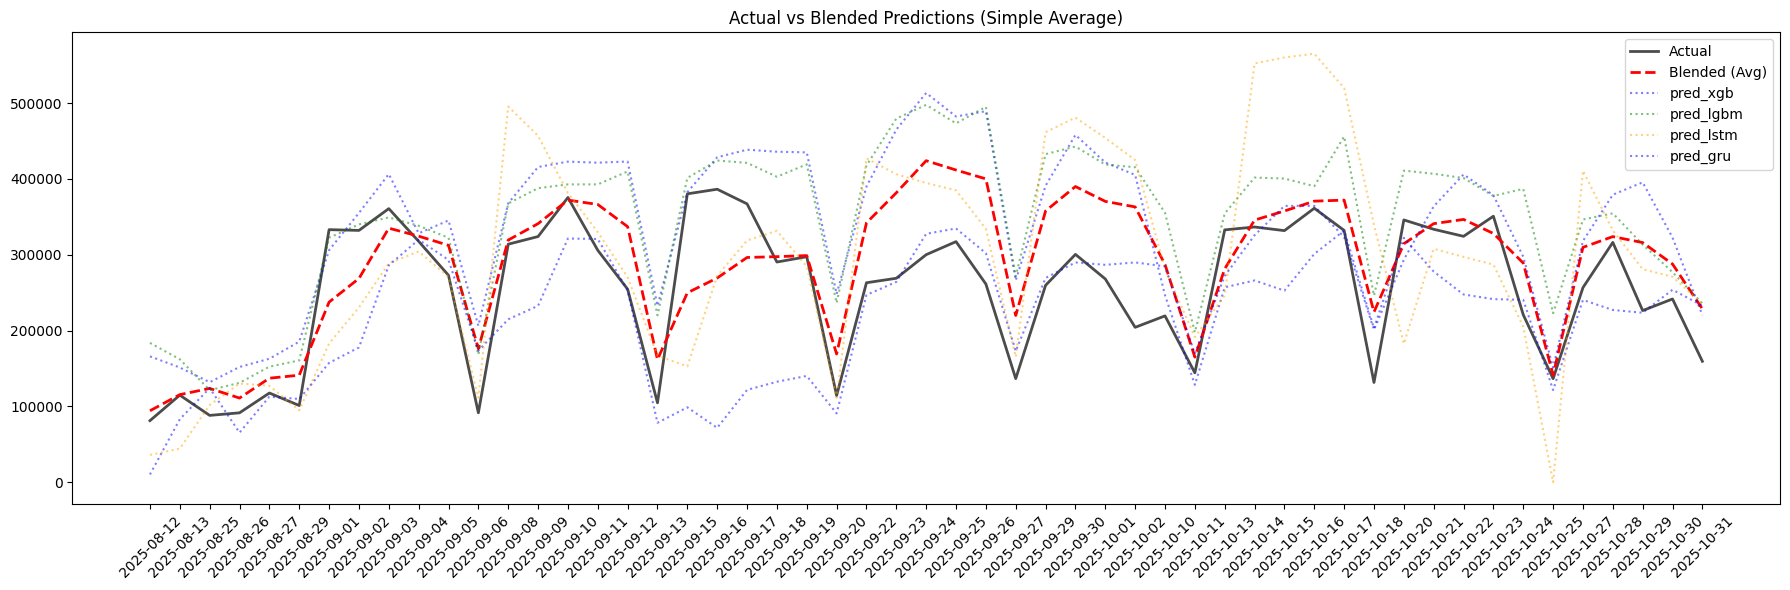


결과 저장 완료: blended_prediction_simple.csv


In [ ]:
# =========================
# Ensamble
# =========================

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from IPython.display import display

# ==========================================================
# SMAPE 함수
# ==========================================================
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    # 분모가 0인 경우 처리
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denom[denom == 0] = 1e-8
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

# ==========================================================
# 1. CSV 불러와서 Simple Average Blending 수행
# ==========================================================
def build_simple_blend():

    # 1️⃣ 네 가지 예측 파일 로드
    # (파일 이름은 사용자의 환경에 맞게 수정 필요)
    try:
        xgb_df  = pd.read_csv("xgb_prediction_recursive.csv") # Recursive 결과 사용 권장
        lgb_df  = pd.read_csv("lgbm_prediction_recursive.csv")
        lstm_df = pd.read_csv("lstm_prediction.csv")
        gru_df  = pd.read_csv("gru_prediction.csv")
    except FileNotFoundError:
        print("파일을 찾을 수 없습니다. 파일명을 확인해주세요.")
        return None

    # 2️⃣ 컬럼명 통일
    xgb_df  = xgb_df.rename(columns={"pred_daily": "pred_xgb"})
    lgb_df  = lgb_df.rename(columns={"pred_daily": "pred_lgbm"})
    lstm_df = lstm_df.rename(columns={"pred_daily": "pred_lstm"})
    gru_df  = gru_df.rename(columns={"예측매출": "pred_gru"})

    # 3️⃣ 날짜 기준으로 inner join
    # 'actual_daily' 컬럼 이름 충돌 방지 (하나만 남김)
    base = xgb_df[["date", "actual_daily", "pred_xgb"]].merge(
        lgb_df[["date", "pred_lgbm"]], on="date", how="inner"
    )
    base = base.merge(lstm_df[["date", "pred_lstm"]], on="date", how="inner")

    # GRU가 있다면 추가
    base = base.merge(gru_df[["date", "pred_gru"]], on="date", how="inner")

    base = base.sort_values("date").reset_index(drop=True)

    print("\n===== 공통 구간 데이터 (샘플) =====")
    display(base.head())

    # 4️⃣ Weighted Blending (가중치 수동 지정)
    # 정답을 보지 않고 사전에 정의한 가중치를 사용하므로 누수 없음.
    # 예: GRU 0.4, 나머지 0.2

    w_gru  = 0.4
    w_xgb  = 0.3
    w_lgbm = 0.2
    w_lstm = 0.1

    # 가중치 합이 1이 되는지 확인 (선택 사항이지만 권장)
    total_w = w_gru + w_xgb + w_lgbm + w_lstm
    if abs(total_w - 1.0) > 1e-9:
        print(f"Warning: 가중치 합이 1이 아닙니다 ({total_w}). 의도한 것이 아니라면 확인 필요.")

    base["pred_blend"] = (
        w_xgb  * base["pred_xgb"] +
        w_lgbm * base["pred_lgbm"] +
        w_lstm * base["pred_lstm"] +
        w_gru  * base["pred_gru"]
    )

    # 5️⃣ 성능 계산 (평가용)
    y_true = base["actual_daily"].values
    blended_pred = base["pred_blend"].values

    mae  = mean_absolute_error(y_true, blended_pred)
    rmse = np.sqrt(mean_squared_error(y_true, blended_pred))
    s_mape = smape(y_true, blended_pred)

    print("\n===== [Simple Average Blending] 성능 =====")
    print(f"MAE   : {mae:,.2f}")
    print(f"RMSE  : {rmse:,.2f}")
    print(f"SMAPE : {s_mape:.2f}%")

    # 6️⃣ 시각화
    models = ["pred_xgb", "pred_lgbm", "pred_lstm", "pred_gru"]
    plt.figure(figsize=(18,6))
    plt.plot(base["date"], base["actual_daily"], label="Actual", linewidth=2, color='black', alpha=0.7)
    plt.plot(base["date"], base["pred_blend"], label="Blended (Avg)", linestyle="--", color='red', linewidth=2)

    # 개별 모델도 옅게 표시
    colors = ['blue', 'green', 'orange']
    for i, model in enumerate(models):
        plt.plot(base["date"], base[model], label=model, linestyle=":", alpha=0.5, color=colors[i%len(colors)])

    plt.title("Actual vs Blended Predictions (Simple Average)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return base

# ==========================================================
# 실행
# ==========================================================
if __name__ == "__main__":
    base_df = build_simple_blend()

    if base_df is not None:
        output_path = "blended_prediction_simple.csv"
        base_df.to_csv(output_path, index=False, encoding="utf-8-sig")
        print(f"\n결과 저장 완료: {output_path}")
